In [5]:
# You can replace the path with any new generated dataset.
DATA_DIR = 'logs/fork/renderonly_train_049999'

source image,target image

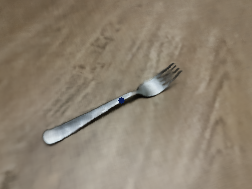
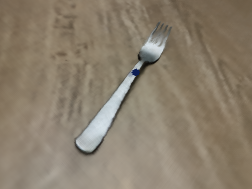

In [36]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import numpy as np
import time
import cv2
import mediapy as media
from glob import glob
from PIL import Image
from torchvision import transforms
from IPython.display import clear_output


def reprojection(uv_A, z_A, c2w_A, c2w_B, K):
    """
    Args
        uvs_A: of shape (n_uvs, 2) 
    """
    pt_z_A = z_A[uv_A[1], uv_A[0]][None, :, None]  # (1, n_depths, 1)
    n_depths = pt_z_A.shape[1]
    xyz_A_camera = (np.stack([uv_A[0], uv_A[1], 1])[None, None, :] * pt_z_A) @ np.linalg.inv(K).T
    # xyz_A_camera has shape (1, n_depths, 3).
    
    xyz_A_world = np.concatenate([xyz_A_camera, np.ones([1, n_depths, 1])], axis=2) @ c2w_A.T
    # xyz_A_world has shape (1, n_depths, 4).
    uvs_B = (xyz_A_world @ np.linalg.inv(c2w_B).T)[:, :, :3] @ K.T
    uvs_B = (uvs_B[:, :, :2] / uvs_B[:, :, 2:]).astype(np.int32)
    return uvs_B

def convert_pose(C2W):
    flip_yz = np.eye(4)
    flip_yz[1, 1] = -1
    flip_yz[2, 2] = -1
    C2W = np.matmul(C2W, flip_yz)
    return C2W


n_imgs = len(glob(f"./{DATA_DIR}/rgb/*.png"))

src_idx = np.random.randint(n_imgs)
tgt_idx = np.random.randint(n_imgs)

src_img = Image.open(f'./{DATA_DIR}/rgb/{src_idx:06}.png')
tgt_img = Image.open(f'./{DATA_DIR}/rgb/{tgt_idx:06}.png')
src_z = np.load(f'./{DATA_DIR}/z/{src_idx:06}.npy')
tgt_z = np.load(f'./{DATA_DIR}/z/{tgt_idx:06}.npy')
src_weight = np.load(f'./{DATA_DIR}/weight/{src_idx:06}.npy')
tgt_weight = np.load(f'./{DATA_DIR}/weight/{tgt_idx:06}.npy')
src_c2w = np.loadtxt(f'./{DATA_DIR}/pose/{src_idx:06}.txt')
tgt_c2w = np.loadtxt(f'./{DATA_DIR}/pose/{tgt_idx:06}.txt')
K = np.loadtxt(f'./{DATA_DIR}/intrinsics.txt')

# Convert poses from OpenCV to OpenGL
src_c2w = convert_pose(src_c2w)
tgt_c2w = convert_pose(tgt_c2w)

W, H = src_img.size
src_img_tensor = transforms.ToTensor()(src_img)
tgt_img_tensor = transforms.ToTensor()(tgt_img)


def draw_images(u_A, v_A):
    uvs_B = reprojection([u_A, v_A], src_z, src_c2w, tgt_c2w, K)

    color = tuple((255*np.random.rand(3)).tolist())
    img_A_draw = np.array(src_img).copy()
    img_A_draw = cv2.circle(img_A_draw, tuple([u_A, v_A]), 3, color, -1)
    img_B_draw = np.array(tgt_img).copy()
    for idx_pt in range(uvs_B.shape[0]):
        for idx_depth in range(uvs_B.shape[1]):
            img_B_overlay = img_B_draw.copy()
            img_B_overlay = cv2.circle(img_B_overlay, tuple(uvs_B[idx_pt][idx_depth]), 3, color, -1)
            alpha = src_weight[v_A, u_A][idx_depth] * 10
            img_B_draw = cv2.addWeighted(img_B_overlay, alpha, img_B_draw, 1 - alpha, 0)
    media.show_images({'source image': img_A_draw, 'target image': img_B_draw})


def onclick(event):
    clear_output(wait=True)
    u_A, v_A = int(event.xdata), int(event.ydata)
    draw_images(u_A, v_A)

fig = plt.figure(figsize=(6,3))
plt.title('source image')
cid = fig.canvas.mpl_connect('button_press_event', onclick)
imgplot = plt.imshow(src_img)
plt.show()